In [31]:
# %load ./init.ipy
%reload_ext autoreload
%autoreload 2
from importlib import reload

import os
import sys
import logging
import warnings
import numpy as np
import astropy as ap
import scipy as sp
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt

import h5py
import tqdm.notebook as tqdm

import kalepy as kale
import kalepy.utils
import kalepy.plot

import holodeck as holo
import holodeck.sam
from holodeck import cosmo, utils, plot
from holodeck.constants import MSOL, PC, YR, MPC, GYR

# Silence annoying numpy errors
np.seterr(divide='ignore', invalid='ignore', over='ignore')
warnings.filterwarnings("ignore", category=UserWarning)

# Plotting settings
mpl.rc('font', **{'family': 'serif', 'sans-serif': ['Times'], 'size': 15})
mpl.rc('lines', solid_capstyle='round')
mpl.rc('mathtext', fontset='cm')
plt.rcParams.update({'grid.alpha': 0.5})
mpl.style.use('default')   # avoid dark backgrounds from dark theme vscode

log = holo.log
log.setLevel(logging.INFO)

# Quick: Population, Evolution, GW Spectrum

calculating hardening normalization:   0%|          | 0/14 [00:00<?, ?it/s]

evolving binaries:   0%|          | 0/99 [00:00<?, ?it/s]

GW frequencies:   0%|          | 0/66 [00:00<?, ?it/s]

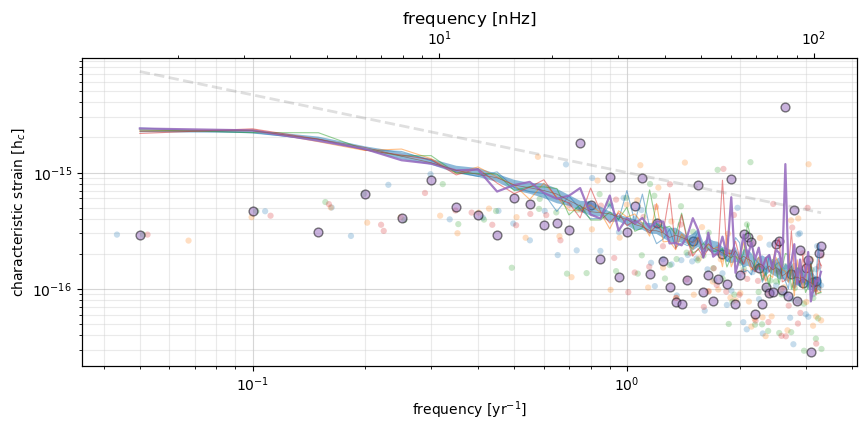

In [32]:
# ---- Create initial population

pop = holo.Pop_Illustris()

# ---- Apply population modifiers

# resample to increase the number of binaries
mod_resamp = holo.PM_Resample(resample=5.0)
# modify population (in-place)
pop.modify(mod_resamp)

# ---- Evolve binary population

# create a fixed-total-time hardening mechanism
fixed = holo.evolution.Fixed_Time.from_pop(pop, 2.0 * GYR)
# add population and hardening to an evolution instance
evo = holo.evolution.Evolution(pop, fixed)
# evolve binary population
evo.evolve()

# ---- Calculate and Plot GWB

# construct sampling frequencies
freqs = holo.utils.nyquist_freqs(dur=20.0*YR, cad=0.3*YR)
# calculate discretized GW signals
gwb = holo.gravwaves.GW_Discrete(evo, freqs, nreals=30)
gwb.emit()

plot.plot_gwb(gwb)
plt.show()

# Step-by-Step

## Construct Illustris-Based Binary Population

In [33]:
pop = holo.Pop_Illustris()
ill_name = os.path.basename(pop._fname).split('_')[1]
print("Loaded", pop.size, "binaries from Illustris", ill_name)

Loaded 2749 binaries from Illustris L75n1820FP


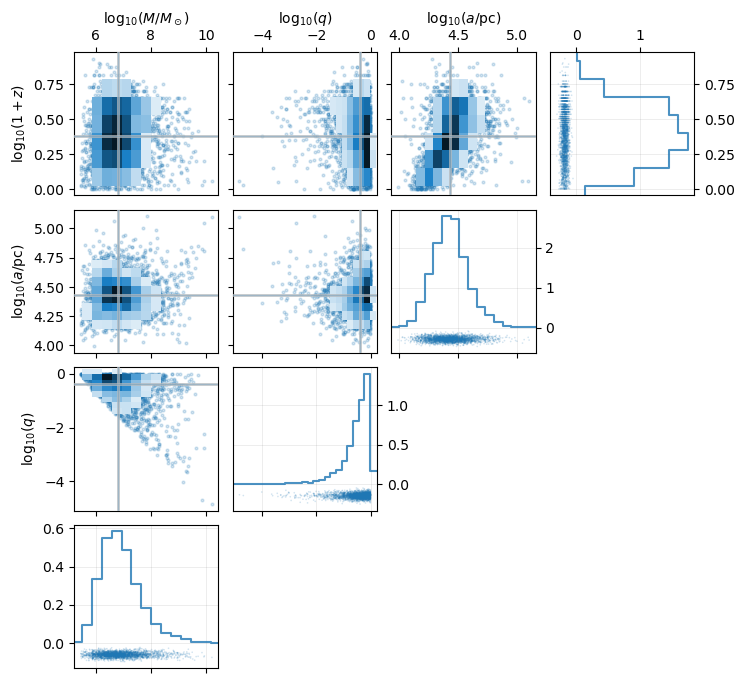

In [34]:
plot.plot_bin_pop(pop)
plt.show()

### Apply a modifier to resample binary population by 5x

In [35]:
mod_resamp = holo.PM_Resample(resample=5.0)
pop.modify(mod_resamp)
print("Population now has", pop.size, "elements")

Population now has 13745 elements


### Apply Modifer to Use McConnell+Ma 2013 BH masses

Masses before:  8.66e+04, 5.62e+05, 2.58e+06, 1.73e+07, 2.01e+10
Masses after :  7.96e+03, 6.54e+05, 5.60e+06, 4.79e+07, 3.16e+10
Plotting 3.0e+03/2.7e+04 data-points


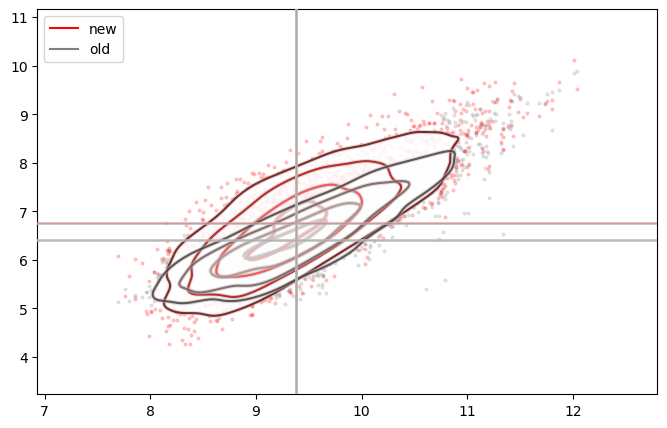

In [36]:
# Create the modifier using M-Host relation
#mmbulge = holo.relations.MMBulge_MM13_ZEvolution(zplaw = 2.0)
#mmbulge = holo.relations.MMBulge_MM13()
msigma = holo.relations.MSigma_KH13()
#mmbulge = holo.relations.MMBulge_Strawman()
# Try replacing "msigma" below with one of the above holo.relations
mod_mm13 = holo.PM_Mass_Reset(msigma, scatter=True)

# Choose percentiles
percs = 100*sp.stats.norm.cdf([-1, 0, 1])
percs = [0,] + percs.tolist() + [100,]

# Format nicely
str_array = lambda xx: ", ".join(["{:.2e}".format(yy) for yy in xx])
str_masses = lambda xx: str_array(np.percentile(xx/MSOL, percs))

# Modify population
print("Masses before: ", str_masses(pop.mass))
pop.modify(mod_mm13)
print("Masses after : ", str_masses(pop.mass))
    
plot.plot_mbh_scaling_relations(pop)
plt.show()

# Binary Evolution

In [37]:
# Set timescale for all binaries to merge over
fix_time = 2.0 * GYR
# Construct 'hardening' instance for this fixed time
fixed = holo.evolution.Fixed_Time.from_pop(pop, fix_time)
# Construct evolution instance using fixed time hardening
evo = holo.evolution.Evolution(pop, fixed)
# Evolve population
evo.evolve()

calculating hardening normalization:   0%|          | 0/14 [00:00<?, ?it/s]

evolving binaries:   0%|          | 0/99 [00:00<?, ?it/s]

## Compare resulting lifetimes to targeted lifetime

Make sure that the resulting evolution timescale is consistent with the desired timescale (`fix_time`).
It's okay if there is some difference (a few percent) as the method is approximate.

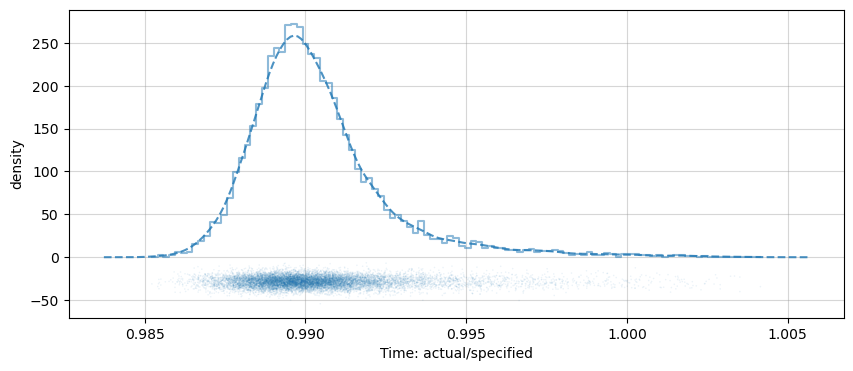

In [38]:
# Calculate the total lifetime of each binary
time = evo.tlbk
dt = time[:, 0] - time[:, -1]

# Create figure
fig, ax = plot.figax(scale='lin', xlabel='Time: actual/specified', ylabel='density')
# use kalepy to plot distribution
kale.dist1d(dt/fix_time, density=True)

plt.show()

## Plot Hardening Rate vs. Separation

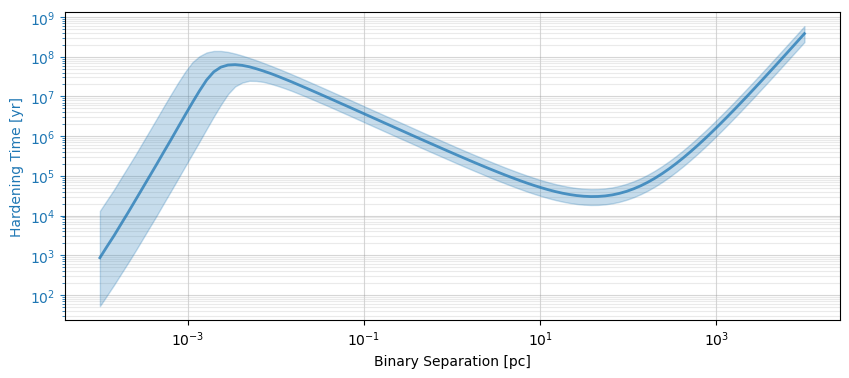

In [39]:
# Create spacing in separation (xaxis) to plot against
sepa = np.logspace(-4, 4, 100) * PC
# Plot hardening rates
plot.plot_evo(evo, sepa=sepa)

plt.show()

## Plot Hardening Rate vs. Frequency

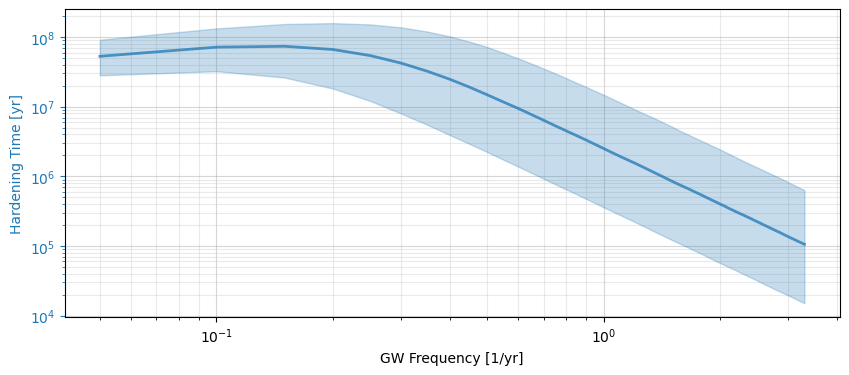

In [40]:
# Create frequency spacing (xaxis) to plot against
# freqs = np.logspace(-2, 1, 20) / YR
freqs = holo.utils.nyquist_freqs(20.0, 0.3) / YR

plot.plot_evo(evo, freqs=freqs)
plt.show()

# Calculate GWB

In [41]:
# freqs = holo.utils.nyquist_freqs(20.0, 0.3) / YR
gwb = holo.GW_Discrete(evo, freqs, nreals=5)
gwb.emit()

GW frequencies:   0%|          | 0/66 [00:00<?, ?it/s]

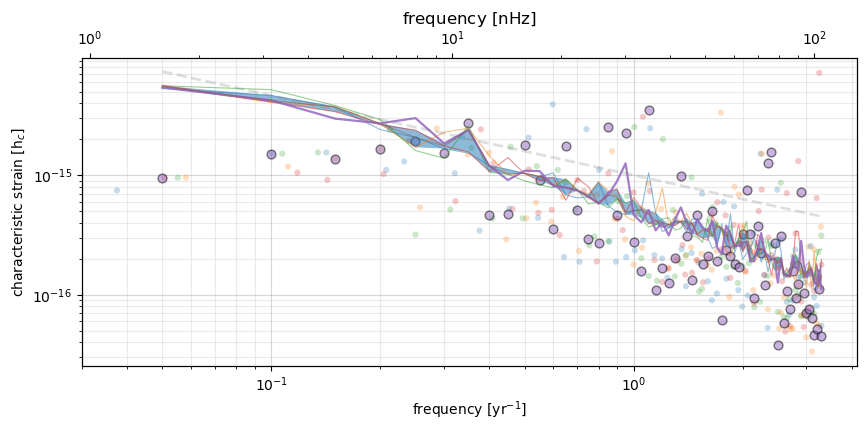

In [42]:
plot.plot_gwb(gwb)
plt.show()